In [1]:
import pyreadr 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import xgboost as xgb
import itertools
from scipy import stats
from scipy.special import digamma
import os

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')


features = list(data_ml.columns[2:95])
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

In [3]:
sep_oos = dt.strptime("2007-01-01","%Y-%m-%d")
ticks = data_ml['stock_id'].unique()
N = len(ticks)
t_oos = returns[returns.index>sep_oos].index.unique()
Tt = len(t_oos)
nb_port = 2
portf_weights = np.zeros((Tt, nb_port, N))
portf_returns = np.zeros((Tt, nb_port))

In [4]:
def weights_xgb(train_data, test_data, features):
    train_features = train_data[features]
    train_label = train_data.R12M_Usd / np.exp(train_data.Vol1Y_Usd)
    ind = (train_label > train_label.quantile(0.8)) | (train_label < train_label.quantile(0.2))
    train_features = train_features[ind]
    train_label = train_label[ind]
    
    model = xgb.XGBRegressor(     
                  learning_rate  = 0.3,       #Boosting learning rate                  
                  objective = "reg:squarederror",    
                  max_depth = 4,              #Maximum tree depth for base learners.                              
                  n_estimators = 80,          #Number of trees in random forest to fit.
                  verbosity = 0,         
                    )
    model.fit(train_features,train_label )
    xgb_test = test_data[features]
    
    pred = model.predict(xgb_test)
    w = pred > np.median(pred)
    w = pd.DataFrame(w / np.sum(w), columns=['weights'])
    w['names'] = test_data.stock_id.unique()
    return w

In [5]:
def portf_compo(train_data, test_data, features, j):
    if j == 0:  
        N = len(test_data.stock_id.unique())
        w = pd.DataFrame(np.tile(1/N, N), columns=['weights'])
        w['names'] = test_data.stock_id.unique()
        return w
    if j == 1:  
        return weights_xgb(train_data, test_data, features)

In [6]:
m_offset = 12
train_size = 5
for t in range(len(t_oos)-1):
    if t % 12 == 11:
        print(t_oos[t])
    train_data = data_ml[ (data_ml.date < (t_oos[t] - pd.Timedelta(days=m_offset * 30))) &  
                         (data_ml.date > (t_oos[t]  - pd.Timedelta(days= m_offset * 30 + 365 * train_size))) ]
    test_data = data_ml[data_ml.date == t_oos[t]]
    realized_returns = test_data.R1M_Usd
    for j in range(2):
        temp_weights = portf_compo(train_data, test_data, features, j)
        temp_ticks = pd.Index(ticks)
        ind = temp_ticks.get_indexer(temp_weights.names)
        ind = np.array(ind)
        ind = ind[ind>=0]

        portf_weights[t,j,ind] = temp_weights.weights           # Allocate weights 
        portf_returns[t,j] = np.dot(temp_weights.weights, realized_returns)

2007-12-31 00:00:00
2008-12-31 00:00:00
2009-12-31 00:00:00
2010-12-31 00:00:00
2011-12-31 00:00:00
2012-12-31 00:00:00
2013-12-31 00:00:00
2014-12-31 00:00:00
2015-12-31 00:00:00
2016-12-31 00:00:00
2017-12-31 00:00:00


In [7]:
def turnover(weights, asset_returns, t_oos):
    turn = 0
    for t in range(1,len(t_oos)):
        realised_returns = asset_returns[asset_returns.index == t_oos[t]].values
        prior_weights = weights[t-1] * (1 + realised_returns) 
        turn += np.sum(np.abs(weights[t] - prior_weights / np.sum(prior_weights)))
    print(turn)
    return turn/(len(t_oos)-1)

In [8]:
def perf_met(portf_returns, weights, asset_returns, t_oos):
    avg_ret = np.nanmean(portf_returns)
    vol = np.nanstd(portf_returns)
    Sharpe_ratio = avg_ret / vol
    VaR_5 = np.nanpercentile(portf_returns, 0.05) #np.quantile ignore na value
    turn = turnover(weights, asset_returns, t_oos)

    met = pd.DataFrame({'avg_ret': [avg_ret], 
                        'vol': [vol], 
                        'Sharpe_ratio':[Sharpe_ratio], 
                        'VaR_5':[VaR_5], 
                        'turn':[turn] 
                        }, index=["metrics"])
    return met

In [9]:
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):
    J = weights.shape[1]
    met = []
    for j in range(J):
        met.append(perf_met(portf_returns[:, j], weights[:, j, :], asset_returns, t_oos))

    met = pd.concat(met, axis=0)
    met.index = strat_name
    return met

In [10]:
asset_returns = data_ml.pivot_table(index='date',columns='stock_id',values='R1M_Usd')
asset_returns = asset_returns.fillna(0)

met = perf_met_multi(
            portf_returns = portf_returns,  
            weights = portf_weights, 
            asset_returns = asset_returns,
            t_oos = t_oos,
            strat_name = ["EW", "XGB_SR"]
)
met

10.217521300626153
80.45239743934795


,avg_ret,vol,Sharpe_ratio,VaR_5,turn
EW,0.009697,0.056233,0.172448,-0.202855,0.071451
XGB_SR,0.012316,0.062726,0.196340,-0.223677,0.562604


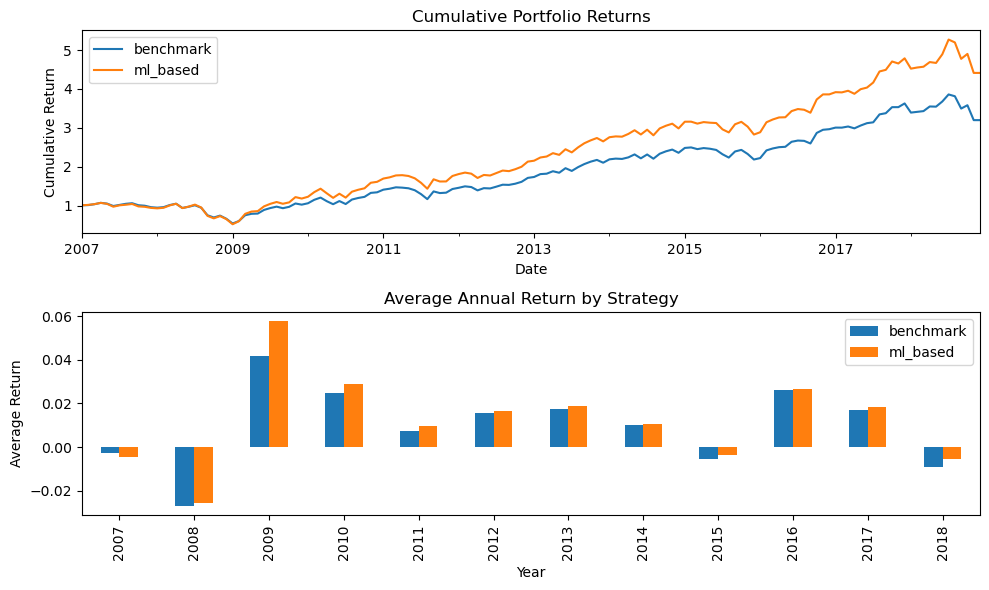

In [11]:
g1 = pd.DataFrame({
    "date": t_oos,
    "benchmark": np.cumprod(1 + portf_returns[:, 0]),
    "ml_based": np.cumprod(1 + portf_returns[:, 1])
}).set_index('date')

g2 = pd.DataFrame({
    "year": pd.to_datetime(t_oos).year,
    "benchmark": portf_returns[:, 0],
    "ml_based": portf_returns[:, 1]
})
g2 = g2.groupby('year').mean()

fig, axes = plt.subplots(nrows=2, figsize=(10, 6))
g1.plot(ax=axes[0])
axes[0].set_title("Cumulative Portfolio Returns")
axes[0].set_ylabel("Cumulative Return")
axes[0].set_xlabel("Date")
g2.plot.bar(ax=axes[1])
axes[1].set_title("Average Annual Return by Strategy")
axes[1].set_ylabel("Average Return")
axes[1].set_xlabel("Year")

plt.tight_layout()
plt.show()


In [12]:
def strat(data, feature, thresh, direction):
    data_tmp = data[[feature, 'date', 'R1M_Usd']].copy() 
    data_tmp['decision'] = (direction * data_tmp[feature] > direction * thresh)
    grouped = data_tmp.groupby('date')
    nb = grouped['decision'].transform('sum')
    data_tmp['w'] = np.where(nb > 0, data_tmp['decision'] / nb, 0)
    data_tmp['return_val'] = data_tmp['w'] * data_tmp['R1M_Usd']
    p_return = grouped['return_val'].sum()
    metrics = pd.DataFrame({'avg': p_return.mean(), 'sd': p_return.std(), 'SR': [p_return.mean()/ p_return.std()]})
    
    return metrics


In [13]:
strat(data_ml, "Pb", 0.3, 1)

,avg,sd,SR
0,0.010235,0.049553,0.206538


In [14]:
feature = ["Div_Yld", "Ebit_Bv", "Mkt_Cap_6M_Usd", "Mom_11M_Usd", "Pb", "Vol1Y_Usd"]
thresh = np.arange(0.2, 0.9, 0.1)
direction = np.array([1,-1])
param_grid = list(itertools.product(feature, thresh, direction))

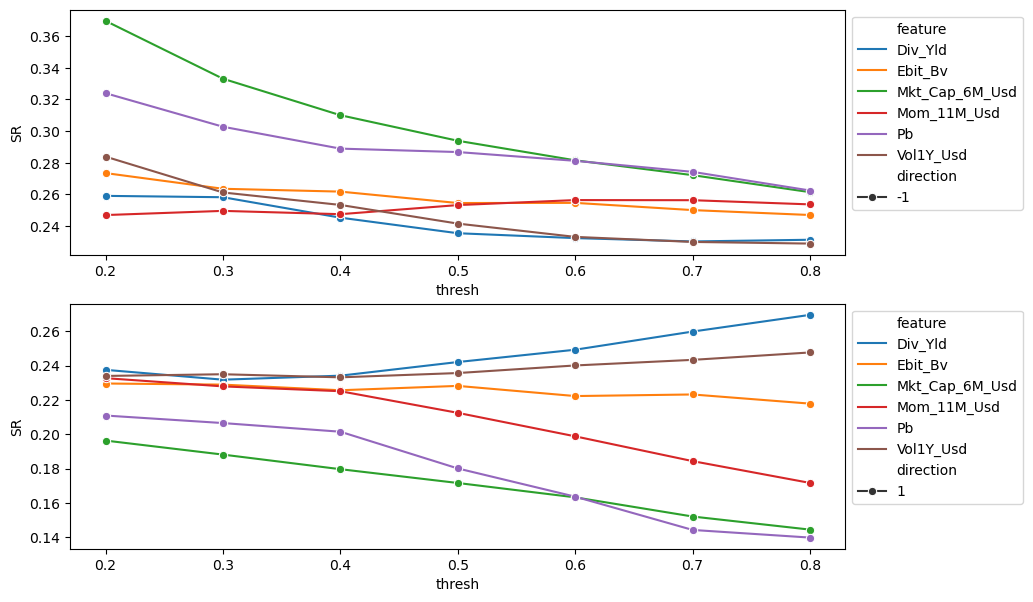

In [15]:
results = list(map(lambda p: strat(data_ml, *p), param_grid))
grd = np.vstack(results)  
grd_df = pd.DataFrame(param_grid, columns=["feature", "thresh", "direction"]) 
grd_df[["mean", "sd", "SR"]] = grd 
fig, axes = plt.subplots(nrows=2, figsize=(10, 7))
sns.lineplot(data=grd_df[grd_df['direction']==-1], x="thresh", y="SR", hue="feature", style="direction", markers=True, ax=axes[0])
sns.lineplot(data=grd_df[grd_df['direction']==1], x="thresh", y="SR", hue="feature", style="direction", markers=True, ax=axes[1])
for ax in axes:
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))  

In [16]:
def DSR(SR, Tt, M, g3, g4, SR_m, SR_v):
    gamma = -digamma(1)
    SR_star = SR_m + np.sqrt(SR_v) * ((1 - gamma) * stats.norm.ppf(1 - 1/M) + gamma * stats.norm.ppf(1 - 1/(M * np.exp(1))))
    num = (SR - SR_star) * np.sqrt(Tt - 1)  
    den = np.sqrt(1 - g3 * SR + ((g4 - 1) / 4) * SR**2)  
    return stats.norm.cdf(num / den) 


In [17]:
M = len(param_grid)                                                                                               
SR = grd_df['SR'].max()                                                                                       
SR_m = grd_df['SR'].mean()                                                                                       
SR_v = grd_df['SR'].var()

data_tmp = data_ml[['Mkt_Cap_6M_Usd', 'date', 'R1M_Usd']].copy()
data_tmp.rename(columns={"Mkt_Cap_6M_Usd": "feature"}, inplace=True)                                                                                              
data_tmp["decision"] = (data_tmp["feature"] < 0.2)

grouped = data_tmp.groupby("date")
nb = grouped["decision"].transform("sum")  
data_tmp["w"] = np.where(nb > 0, data_tmp["decision"] / nb, 0) 
data_tmp["return_val"] = data_tmp["w"] * data_tmp["R1M_Usd"] 
returns_DSR = data_tmp.groupby("date")["return_val"].sum().reset_index(name="p_return")
g3 = stats.skew(returns_DSR["p_return"])
g4 = stats.kurtosis(returns_DSR["p_return"]) + 3
Tt = len(returns_DSR) 
DSR(SR, Tt, M, g3, g4, SR_m, SR_v)

0.6658448940004084